In [ ]:
!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 4.6.0
Uninstalling gdown-4.6.0:
  Successfully uninstalled gdown-4.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gdown-4.6.0-py3-none-any.whl (14 kB)
gdown 4.6.0 at /usr/local/lib/python3.8/dist-packages


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/COVID'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/COVID'
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [ ]:
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 50
batch_size = 32

#define paths
covid_path = '/content/drive/MyDrive/Data/COVID-19'
normal_path = '/content/drive/MyDrive/Data/NORMAL'
viral_pneumonia_path = '/content/drive/MyDrive/Data/Viral Pneumonia'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
normal_files = glob(normal_path + '/*')
viral_pneumonia_files = glob(viral_pneumonia_path + '/*')

In [ ]:
# Preparing Labels
viral_pneumonia_labels = []
normal_labels = []


viral_pneumonia_images=[]
normal_images=[]


import cv2

for i in range(len(viral_pneumonia_files)):
  image = cv2.imread(viral_pneumonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  viral_pneumonia_images.append(image)
  viral_pneumonia_labels.append('Chest_viral_pneumonia')

print("part1 done")


print("part2 done")
for i in range(len(normal_files)):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('Chest_Normal')
print("part3 done")

part1 done
part2 done
part3 done


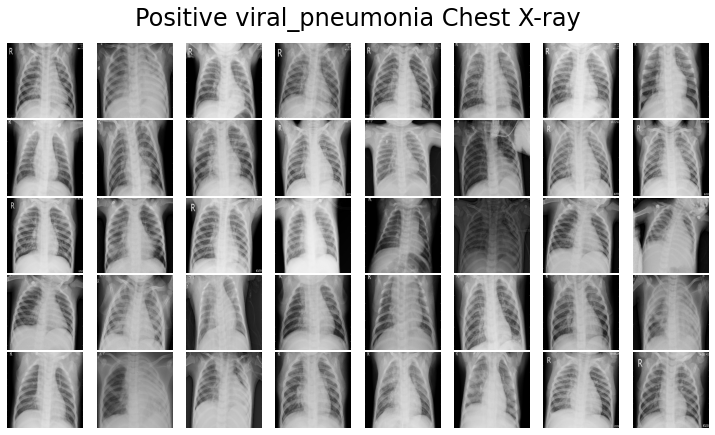

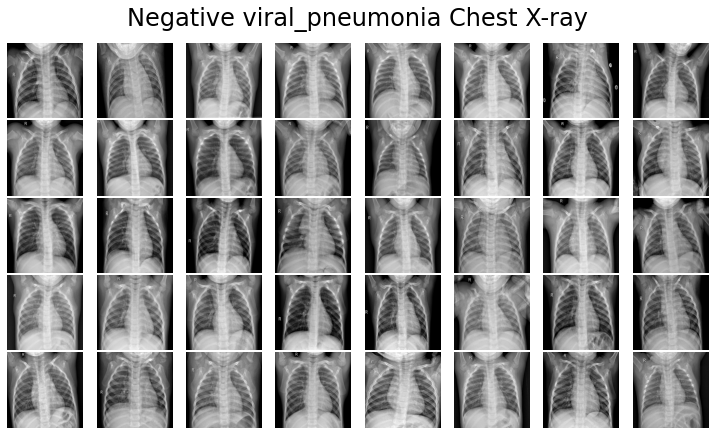

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(viral_pneumonia_images, 'Positive viral_pneumonia Chest X-ray')
plot_images(normal_images, 'Negative viral_pneumonia Chest X-ray')

Normalization

In [ ]:
# normalize to interval of [0,1]
viral_pneumonia_images = np.array(viral_pneumonia_images) / 255
normal_images = np.array(normal_images) / 255

Train Test Split

In [ ]:
!pip install install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
viral_pneumonia_x_train, viral_pneumonia_x_test, viral_pneumonia_y_train, viral_pneumonia_y_test = train_test_split(
    viral_pneumonia_images, viral_pneumonia_labels, test_size=0.2)
nonviral_pneumonia_x_train, nonviral_pneumonia_x_test, nonviral_pneumonia_y_train, nonviral_pneumonia_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)


X_train = np.concatenate((nonviral_pneumonia_x_train, viral_pneumonia_x_train), axis=0)
X_test = np.concatenate((nonviral_pneumonia_x_test, viral_pneumonia_x_test), axis=0)
y_train = np.concatenate((nonviral_pneumonia_y_train, viral_pneumonia_y_train), axis=0)
y_test = np.concatenate((nonviral_pneumonia_y_test, viral_pneumonia_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

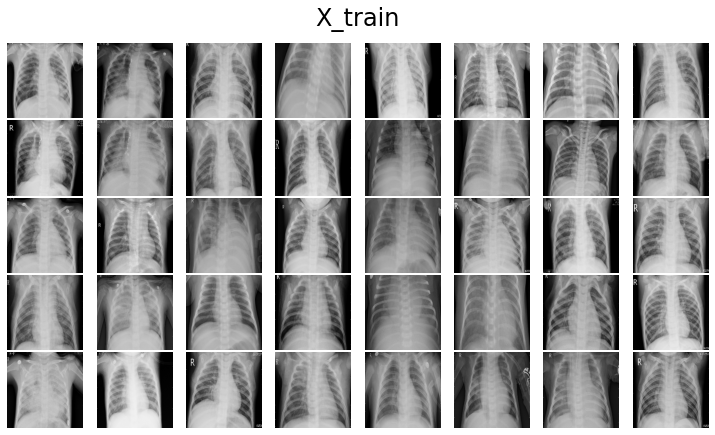

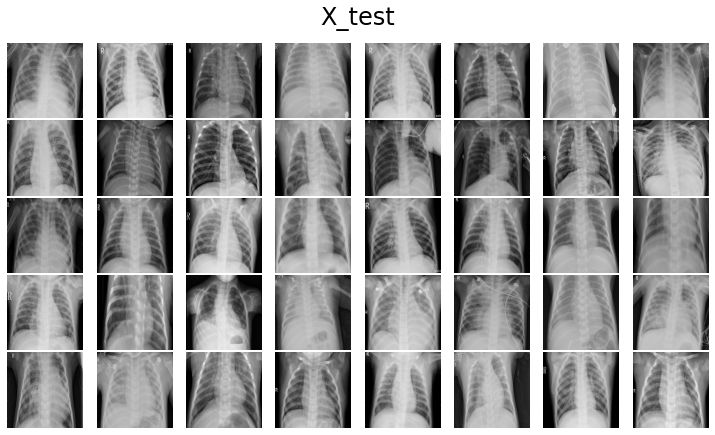

In [ ]:
plot_images(viral_pneumonia_x_train, 'X_train')
plot_images(viral_pneumonia_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

Building and Visualizing model

In [ ]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

Training the model

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=100)

Epoch 1/100
40/40 [==============================] - 28s 400ms/step - loss: 2.3306 - accuracy: 0.5750 - val_loss: 0.4968 - val_accuracy: 0.8031
Epoch 2/100
40/40 [==============================] - 15s 381ms/step - loss: 0.7345 - accuracy: 0.7023 - val_loss: 0.5438 - val_accuracy: 0.7937
Epoch 3/100
40/40 [==============================] - 15s 374ms/step - loss: 0.5566 - accuracy: 0.7547 - val_loss: 0.4999 - val_accuracy: 0.8188
Epoch 4/100
40/40 [==============================] - 15s 375ms/step - loss: 0.6621 - accuracy: 0.7570 - val_loss: 0.4321 - val_accuracy: 0.8594
Epoch 5/100
40/40 [==============================] - 15s 367ms/step - loss: 0.7309 - accuracy: 0.7250 - val_loss: 0.4352 - val_accuracy: 0.8750
Epoch 6/100
40/40 [==============================] - 15s 368ms/step - loss: 0.4501 - accuracy: 0.8250 - val_loss: 0.3369 - val_accuracy: 0.8969
Epoch 7/100
40/40 [==============================] - 15s 373ms/step - loss: 0.4672 - accuracy: 0.8219 - val_loss: 0.4310 - val_accuracy:

In [ ]:
model.save('viral_pneumonia_chest.h5')

In [ ]:
model.save_weights('viral_pneumonia_weights_chest.hdf5')

In [ ]:
model = load_model('viral_pneumonia_chest.h5')

Making Predicions

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

10/10 [==============================] - 2s 95ms/step


Visulaizing First 10 predictions

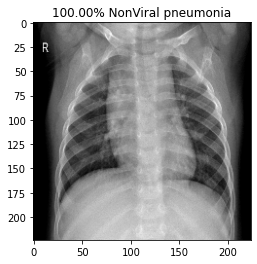

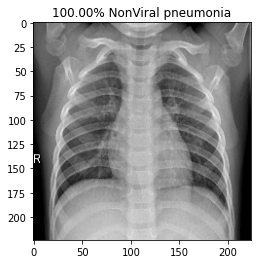

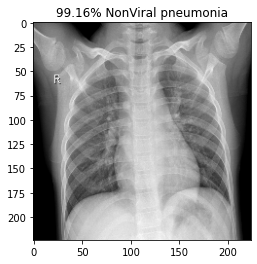

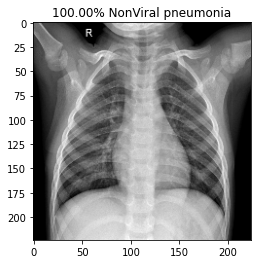

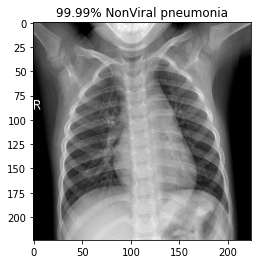

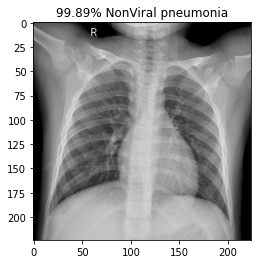

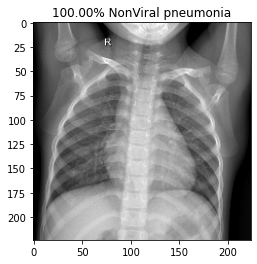

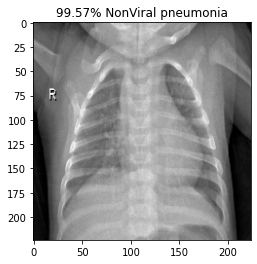

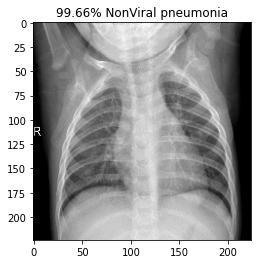

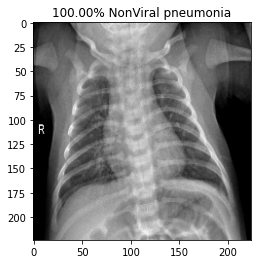

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% viral pneumonia')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonViral pneumonia')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

Plot ROC Curve

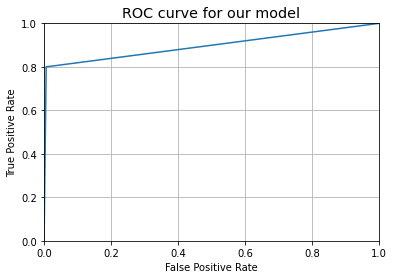

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Plot Confusion Matrix

Confusion Matrix without Normalization


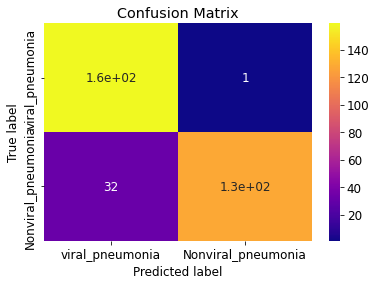

Confusion Matrix with Normalized Values


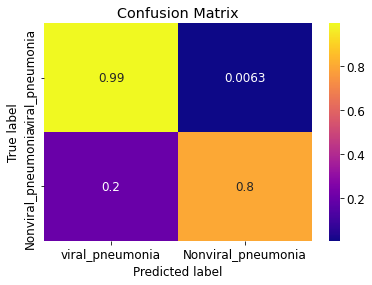

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['viral_pneumonia','Nonviral_pneumonia']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91       160
           1       0.99      0.80      0.89       160

    accuracy                           0.90       320
   macro avg       0.91      0.90      0.90       320
weighted avg       0.91      0.90      0.90       320



Accuracy and Loss Plots

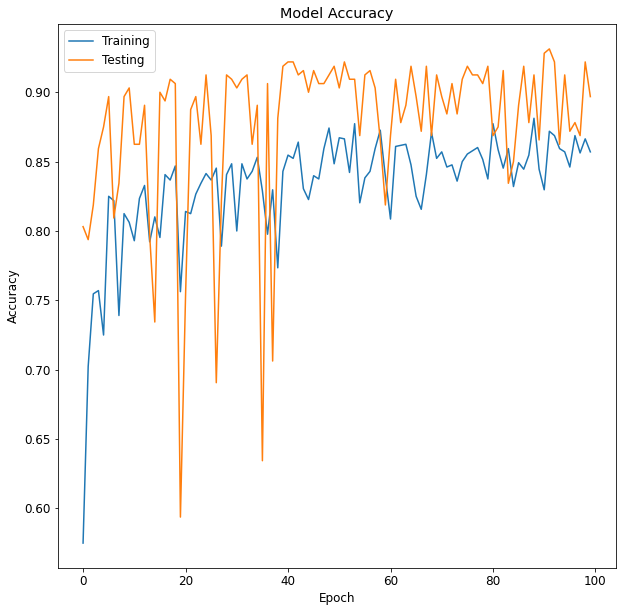

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('viral_pneumonia_chest_accuracy.png')
plt.show()

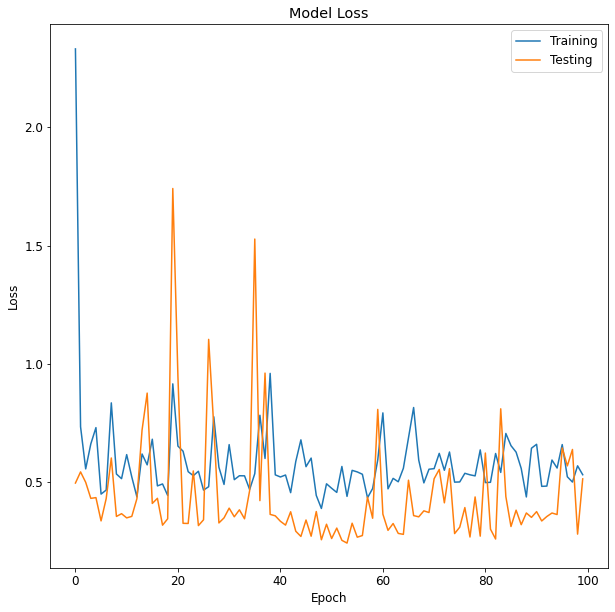

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('viral_pneumonia_chest_loss.png')
plt.show()